In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

In [4]:
sns.set(rc = {'figure.figsize' : (9, 6)})

In [5]:
# импорт данных
event_data = pd.read_csv('event_data_train.csv')
event_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [6]:
submission_data = pd.read_csv('submissions_data_train.csv')
submission_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [7]:
# создание колокнок с датой в привычном формате и с датой без времени
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

In [8]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit = 's')
event_data['day'] = event_data.date.dt.date

<AxesSubplot:xlabel='day'>

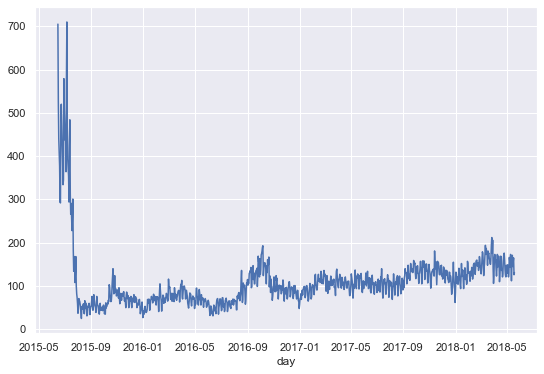

In [9]:
event_data.groupby('day') \
    .user_id.nunique().plot()

In [10]:
user_event_data = event_data.pivot_table(index = 'user_id', 
                       columns = 'action', 
                       values = 'step_id', 
                       aggfunc = 'count', 
                       fill_value = 0) \
                        .reset_index() 
user_event_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [11]:
users_scores = submission_data.pivot_table(index = 'user_id', 
                       columns = 'submission_status', 
                       values = 'step_id', 
                       aggfunc = 'count', 
                       fill_value = 0) \
                        .reset_index()
users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [12]:
gap_data = event_data[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset = ['user_id', 'day']) \
    .groupby('user_id') \
    ['timestamp'] \
    .apply(list) \
        .apply(np.diff).values #создает список из timestamp и считает разницу между timestamp
gap_data #массив массивов

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [13]:
# собираем из массива массивов один массив:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))

In [14]:
# переводим в дни
gap_data = (gap_data/(24*60*60)).to_frame()


In [15]:
gap_data

,0
0,56.060208
1,79.852419
2,2.112083
3,1.084606
4,32.047106
...,...
97867,166.056586
97868,5.845613
97869,1.137176
97870,0.659942


<AxesSubplot:xlabel='0', ylabel='Count'>

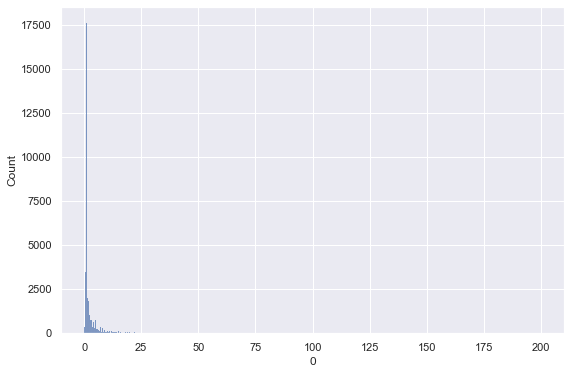

In [16]:
sns.histplot(data = gap_data[gap_data[0] < 200], x = 0)

In [17]:
gap_data.quantile(0.95)

0    59.760441
Name: 0.95, dtype: float64

In [18]:
# вычисление id Карпова
max_score = users_scores.correct.max()
users_scores \
    .query('correct >= @max_score -200')

submission_status,user_id,correct,wrong
439,1046,421,513


In [19]:
# последняя дата в датасете
now = event_data.tail(1).timestamp.to_list()[0]
drop_out_threshold = 30*24*60*60 #30 дней - порог по которому считаем, что юзер выбыл

In [20]:
# последняя дата посещения юзера
users_data = event_data \
    .groupby('user_id', as_index = False) \
    .agg({'timestamp' : 'max'}) \
    .rename(columns = {'timestamp' : 'last_timestamp'})
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [21]:
# считаем сколько времени прошло с now
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [22]:
users_data = users_data \
    .merge(users_scores, how = 'outer', on = 'user_id') \
    .fillna(0)

In [23]:
users_data = users_data.merge(user_event_data, how = 'outer', on = 'user_id')

In [24]:
users_days = event_data \
    .groupby('user_id', as_index = False) \
    .agg({'day': 'nunique'})
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [25]:
users_data = users_data.merge(users_days, how = 'left', on = 'user_id')
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [26]:
# определим пользователей прошедших курс
users_data['passed_course'] = users_data.passed > 170
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [27]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [28]:
# определим за сколько в среднем пользователи проходят курс
users_data[users_data.passed_course == True].day.median()

20.0

<AxesSubplot:>

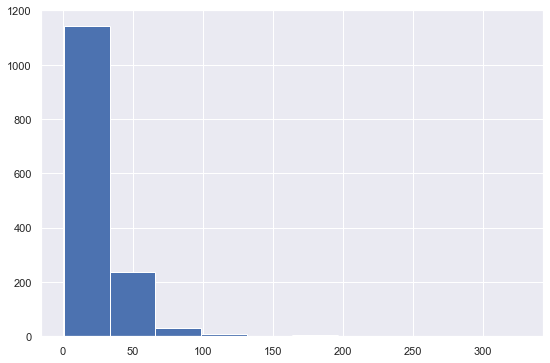

In [29]:
users_data[users_data.passed_course == True].day.hist()

In [30]:
# Посмотрим что делал юзер в первые три дня от момента первого входа
user_min_time = event_data \
    .groupby('user_id', as_index = False) \
    .agg({'timestamp' : 'min'}) \
    .rename(columns = {'timestamp' : 'min_timestamp'})

In [31]:
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [33]:
# добавим эту информацию в наш накопительный DF
users_data = users_data.merge(user_min_time, how = 'inner', on = 'user_id')

In [42]:
# отберем для каждого пользователя те события, которые произошли в течение первых трех дней от самого раннего
learning_time_threshold = 3*24*60*60

In [45]:
event_data_train = event_data \
    .merge(user_min_time, how = 'inner', on = 'user_id') \
    .query('timestamp <= (min_timestamp + @learning_time_threshold)')

event_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [68]:
# Используя данные о сабмитах, для каждого пользователя найдите такой шаг, который он не смог решить, 
# и после этого не пытался решать другие шаги. Затем найдите id шага,  
# который стал финальной точкой практического обучения на курсе для максимального числа пользователей. 

# найдем время последнего шага каждого пользователя:
last_step_time = submission_data \
    .groupby('user_id', as_index = False) \
    .agg({'timestamp' : 'max'}) \
    .rename(columns = {'timestamp' : 'max_timestamp'})

# смержим с данными о сабмитах и выберем степ, который был последним для каждого юзера
last_step = submission_data.merge(last_step_time, how = 'inner', on = 'user_id') \
    .query('timestamp == max_timestamp') \
    [['user_id', 'step_id']]

# подцепим из исходного DF все данные о последнем степе
last_step_data = submission_data.merge(last_step, how = 'inner', on = ['user_id', 'step_id'])

# преобразуем категориальную переменную в числовую
last_step_data = pd.get_dummies(last_step_data, columns = ['submission_status'])

# отбираем тех пользователей, кто не ответил верно на последний степ
final_step = last_step_data \
    .groupby(['user_id','step_id'], as_index = False) \
    .agg({'submission_status_correct' : 'sum'}) \
    .query('submission_status_correct == 0')

# аггрегируем по степам и считаем пользователей
difficult_steps = final_step \
    .groupby('step_id', as_index = False) \
    .agg({'user_id': 'count'}) \
    .rename(columns = {'user_id': 'users_count'}) \
    .sort_values('users_count', ascending = False)

difficult_steps

,step_id,users_count
4,31978,151
28,32812,130
11,32031,95
19,32202,88
42,33481,78
...,...,...
43,33482,1
59,33686,1
57,33684,1
55,33676,1


In [62]:
last_step_data

,step_id,timestamp,user_id,date,day,submission_status_correct,submission_status_wrong
0,33025,1435646053,15853,2015-06-30 06:34:13,2015-06-30,0,1
1,33025,1435646180,15853,2015-06-30 06:36:20,2015-06-30,0,1
2,33025,1435646393,15853,2015-06-30 06:39:53,2015-06-30,0,1
3,33025,1435646933,15853,2015-06-30 06:48:53,2015-06-30,1,0
4,33025,1479734102,15853,2016-11-21 13:15:02,2016-11-21,0,1
...,...,...,...,...,...,...,...
29900,120745,1501946959,2615,2017-08-05 15:29:19,2017-08-05,0,1
29901,120745,1503059927,13177,2017-08-18 12:38:47,2017-08-18,1,0
29902,120745,1506348153,15253,2017-09-25 14:02:33,2017-09-25,0,1
29903,120745,1523035316,1424,2018-04-06 17:21:56,2018-04-06,0,1


In [67]:
final_step


,user_id,step_id,submission_status_correct
4,14,33983,0
6,17,32031,0
8,25,32812,0
11,31,31976,0
13,34,33669,0
...,...,...,...
9884,26666,32031,0
9888,26676,33536,0
9898,26703,33685,0
9910,26737,31981,0
